## [Project repository](https://github.com/A-NGJ/socialgraphs2022)

In [7]:
import os

import pandas as pd
import pickle
import re
import seaborn as sns
import statistics as st
import string 
import typing as t
from tqdm import tqdm

import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


import fa2
try:
    import powerlaw
except ImportError:
    !pip install powerlaw
    import powerlaw

from collections import (
    Counter,
    defaultdict,
)
from community import community_louvain 

from wordcloud import WordCloud



In [4]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

# Basic Stats

In [5]:
class Character:
    """Class containing information about marvel/dc character"""
    
    def __init__(self, name: str, universe: str, data: str):
        self.name = name
        self.universe = universe
        self.data = data
        self.connections = None
        self.n_words = 0
    
    def inspect_data(self, valid_names: t.List[str]):
        """
        Inspect data looking for connections and number of words.
        
        Parameters
        ----------
        valid_names : List of valid character names used in connections search
        """

        re_wikilink = re.compile(r"(?:\[\[)(.*?)(?:\]\])")
        self.connections = set(filter(lambda name: name in valid_names, re_wikilink.findall(self.data)))
        self.n_words = len(re.findall(r"\b\w+\b", self.data))
    
    def __str__(self):
        return str(self.__dict__)
    
class Characters:
    """A wrapper class for storing information about marvel/dc characters"""

    def __init__(self, characters: t.List[Character]):
        self.characters = characters
    
    @classmethod
    def from_dirs(cls, *args):
        """
        Initialize an object using files in provided directories.

        Parameters
        ----------
        args : directories with characters files. They must be named
        the same way as the universe characters are from.

        """
        characters = []
        char_names = []
        paths = []

        # collect files from all supplied directories
        for dir in args:
            if not os.path.isdir(dir):
                print(f"{dir} is not a directory, skipping")
                continue
            for char_file in os.listdir(dir):
                if not os.path.isfile(os.path.join(dir, char_file)):
                    print(f"{path} is not a file, skipping")
                    continue
                # save both path to file and character name for convenienve
                paths.append((dir, char_file))
                char_names.append(char_file.replace(".txt", ""))

        print("reading character files")
        # read content of all files
        for char_name, path in tqdm(zip(char_names, paths), total=len(paths)):
                try:
                    with open(os.path.join(*path), "r", encoding="utf-8") as rfile:
                        # initialize a character and append it to lisr of characters
                        char = Character(
                            name = char_name,
                            universe = path[0],
                            data = rfile.read(),
                        )
                        # look for connections and count words in a document
                        char.inspect_data(char_names)
                        characters.append(char)
                except IOError:
                    print(f"something went wrong when reading {os.path.join(*path)}")
        return cls(characters)

    def get(self, name: str, default=None) -> Character:
        """
        Get a character if present, otherwise default value.

        Parameters
        ----------
        name:
            Character name
        default: [None]
            Default return value if character not found
        
        Returns
        -------
        [Character|default]
        """

        for char in self.characters:
            if char.name == name:
                return char
        return default
    
    @property
    def names(self):
        """Return list of characters names"""
        return [char.name for char in self.characters]
    
    @property
    def marvel(self):
        """Return list of marvel characters only"""
        return [char for char in self.characters if char.universe == "marvel"]
    

    @property
    def dc(self):
        """Return list of dc characters only"""
        return [char for char in self.characters if char.universe == "dc"]

In [8]:
characters = Characters.from_dirs("marvel", "dc")

reading character files


100%|██████████| 2252/2252 [05:27<00:00,  6.88it/s]


Construct a DiGraph of marvel and DC connections

In [9]:
def calc_stats(graph_degrees: nx.Graph):
    """
    Calculate mean, median, mode, min and max of given graph degrees
    
    Returns
    -------
    Namespace
        Namespace with statistics
    """

    class Namespace:
        def __init__(self, **kwargs):
            self.__dict__.update(**kwargs)
        
        def __str__(self):
            return str(self.__dict__)

    degrees = [elem[1] for elem in sorted(graph_degrees, key=lambda x: x[1], reverse=True)]
    return Namespace(
        mean=st.mean(degrees),
        median=st.median(degrees),
        mode=st.mode(degrees),
        min=min(degrees),
        max=max(degrees),
    )

def print_header(title: str):
    """Prints pretty header"""
    print("="*20 + f" {title} " + "="*20 + "\n")

In [10]:
# initialize universe directional graph
Universe = nx.DiGraph()
for character in characters.characters:
    # add node with metadata for each character
    Universe.add_node(character.name, universe=character.universe, n_words=character.n_words)
    for connection in character.connections:
        if connection not in Universe:
            # get character object by its name
            mate = characters.get(connection)
            # if it exists and character connection is not pointing to itself, add node
            # for that connection (mate)
            if mate and mate != character.name:
                Universe.add_node(
                    connection,
                    universe=mate.name,
                    n_words=mate.n_words
                )
        # add edge between character and its connection if it's not a self loop
        if connection != character.name:
            Universe.add_edge(character.name, connection)

In [11]:
print(f"Number of nodes: {len(Universe.nodes)}")
print(f"Number of links: {len(Universe.edges)}")

Number of nodes: 2252
Number of links: 14033


In [12]:
# save graph as an edgelist
nx.write_edgelist(Universe, "data/universe.edgelist")

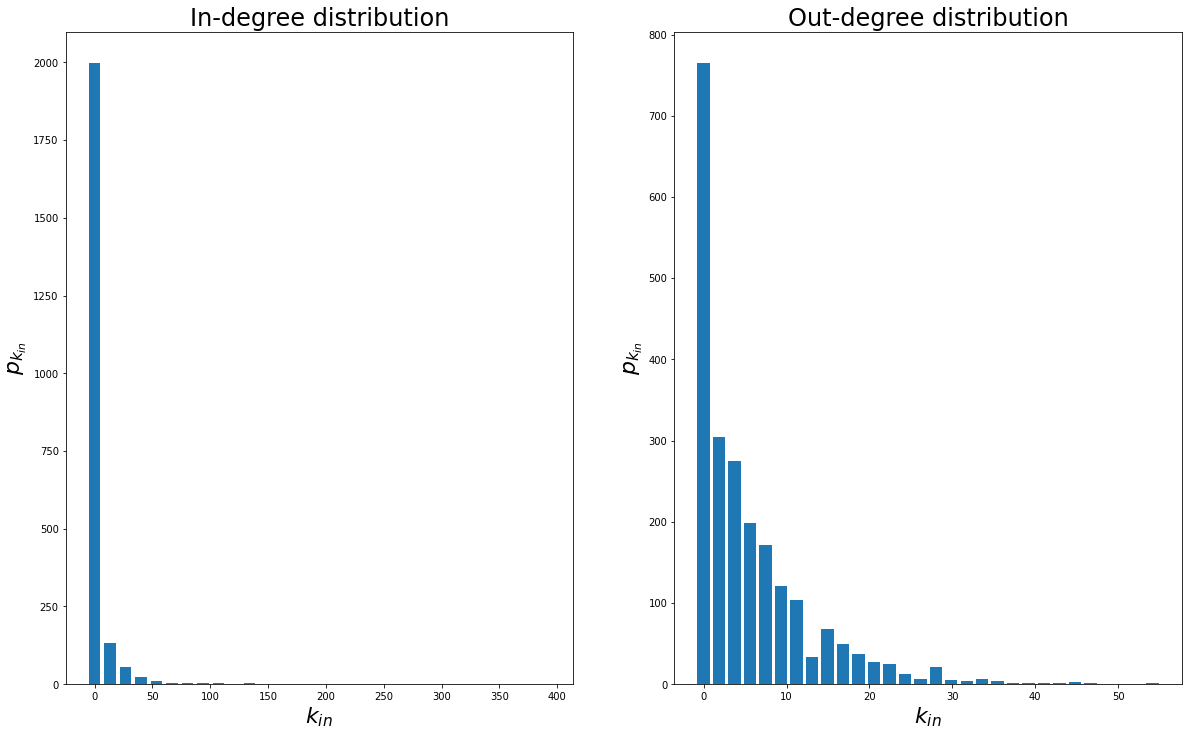

In [13]:
in_degrees = [d for _, d in Universe.in_degree()]
out_degrees = [d for _, d in Universe.out_degree()]

in_hist, in_bins = np.histogram(in_degrees, 30)
out_hist, out_bins = np.histogram(out_degrees, 30)

fig, ax = plt.subplots(1, 2, figsize=(20, 12))
# in degree
bars = ax[0].bar(in_bins[:-1], in_hist, width=10)
ax[0].set_title("In-degree distribution", size=24)
ax[0].set_xlabel("$k_{in}$", size=22)
ax[0].set_ylabel("$p_{k_{in}}$", size=22)
# out degree
ax[1].bar(out_bins[:-1], out_hist, width=1.5)
ax[1].set_title("Out-degree distribution", size=24)
ax[1].set_xlabel("$k_{in}$", size=22)
ax[1].set_ylabel("$p_{k_{in}}$", size=22)
plt.show()

In [14]:
print_header("Universe stats")
in_stats = calc_stats(Universe.in_degree())
out_stats = calc_stats(Universe.out_degree())
print(f"In degree: {in_stats}")
print(f"Out degree: {out_stats}")

==================== Universe stats ====================

In degree: {'mean': 6.231349911190053, 'median': 0.0, 'mode': 0, 'min': 0, 'max': 402}
Out degree: {'mean': 6.231349911190053, 'median': 4.0, 'mode': 0, 'min': 0, 'max': 56}


Slope of the incoming degree distribution

In [15]:
in_degrees = [degree[1] for degree in Universe.in_degree() if degree[1] > 0]
in_degree_alpha = powerlaw.Fit(in_degrees).alpha
print(f"In degree slope: {in_degree_alpha:.2f}")

Calculating best minimal value for power law fit
In degree slope: 2.42


In [16]:
YELLOW = "#fce700"
BLUE = "#00d7fc"
GRAY = "#000000"

largest_component = sorted(nx.weakly_connected_components(Universe), key=len, reverse=True)[0]
Undirected_universe_lc = Universe.subgraph(largest_component).to_undirected()
# set node colors
node_color = ["#e6253e" if Undirected_universe_lc.nodes[node]["universe"] == "marvel" else "#000000" for node in Undirected_universe_lc.nodes]
# set node size
node_size = [Undirected_universe_lc.degree(node)//3 for node in Undirected_universe_lc.nodes]
# edge color
edge_color = []
for node1, node2 in Undirected_universe_lc.edges():
    universe1 = Undirected_universe_lc.nodes[node1]["universe"]
    universe2 = Undirected_universe_lc.nodes[node2]["universe"]
    if universe1 == universe2:
        if universe1 == "marvel":
            edge_color.append(YELLOW)
        else:
            edge_color.append(BLUE)
    else:
        edge_color.append(GRAY)


In [ ]:
# use Force Atlas 2
if not os.path.exists("data/"):
    os.makedirs("data")

FA_POSITIONS = "data/positions.pickle"
# load pickle with pre-calculated positions if present
if os.path.exists(FA_POSITIONS):
    with open(FA_POSITIONS, "rb") as rbfile:
        positions = pickle.load(rbfile)
else:
    positions = fa2.ForceAtlas2().forceatlas2_networkx_layout(Undirected_universe_lc, pos=None, iterations=2000)
    # save to pickle for later use
    with open(FA_POSITIONS, "wb") as wbfile:
        pickle.dump(positions, wbfile)

In [18]:
len(Undirected_universe_lc.nodes)

1746

Network plot using Force Atlas algorithm

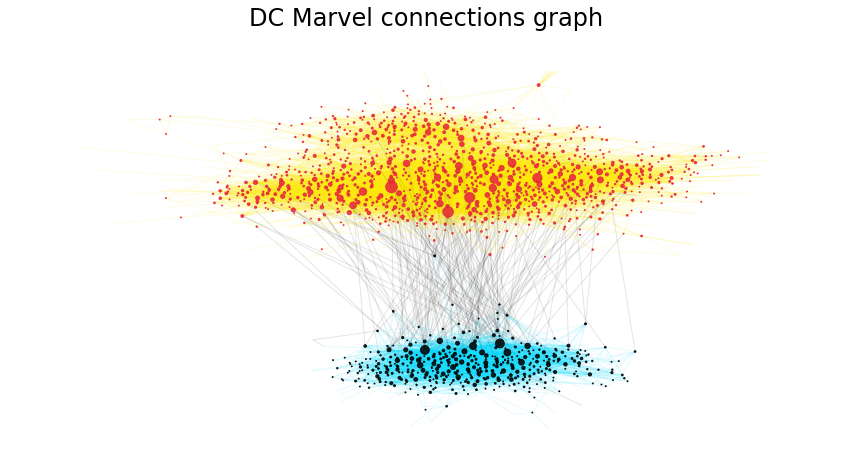

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
nx.draw_networkx_nodes(Undirected_universe_lc, positions, node_color=node_color, node_size=node_size, alpha=0.85, ax=ax)
nx.draw_networkx_edges(Undirected_universe_lc, positions, edge_color=edge_color, alpha=0.1, ax=ax)
ax.set_title("DC Marvel connections graph", size=24)
ax.axis("off")
plt.show()

### Part 2 - communities in Marvel universe

In [26]:
universe = Universe.to_undirected()

### Identify the communities in Marvel universe


In [27]:
marvel_subgraph = universe.subgraph(node for node, data in universe.nodes(data=True) if data.get("universe") == "marvel")
marvel_subgraph = marvel_subgraph.subgraph(node for node in marvel_subgraph.nodes() if marvel_subgraph.degree(node) > 0)
marvel_subgraph = marvel_subgraph.subgraph(sorted(nx.connected_components(marvel_subgraph), key=len, reverse=True)[0])

degrees = [deg for _, deg in marvel_subgraph.degree()]

In [ ]:
# compute the best partition 
partition = community_louvain.best_partition(marvel_subgraph)
# compute graph positions
positions = fa2.ForceAtlas2(strongGravityMode=True).forceatlas2_networkx_layout(marvel_subgraph, pos=None, iterations=2000)

In [29]:
# modularity 
mod = community_louvain.modularity(partition, marvel_subgraph, weight='weight')
print(f"Graph modularity: {mod:.2f}")

Graph modularity: 0.39


In [30]:
node_size = [marvel_subgraph.degree(node) for node in marvel_subgraph.nodes]

In [31]:
# number of communities
set(partition.values())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [32]:
count = Counter(partition.values())
print(count)

Counter({7: 262, 1: 225, 0: 208, 2: 178, 3: 172, 5: 112, 8: 52, 6: 27, 10: 19, 11: 18, 9: 10, 4: 3})


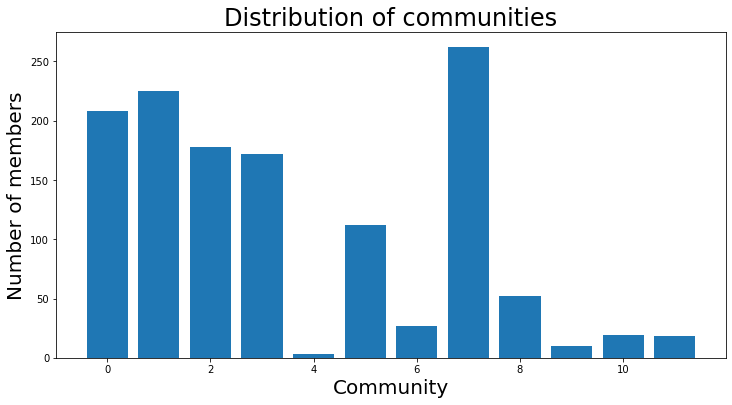

In [67]:
plt.figure(figsize = (12,6))
plt.bar(count.keys(), count.values())
plt.title("Distribution of communities", size=24)
plt.xlabel("Community", size=20)
plt.ylabel("Number of members", size=20)
plt.show()

### Visualize the communities

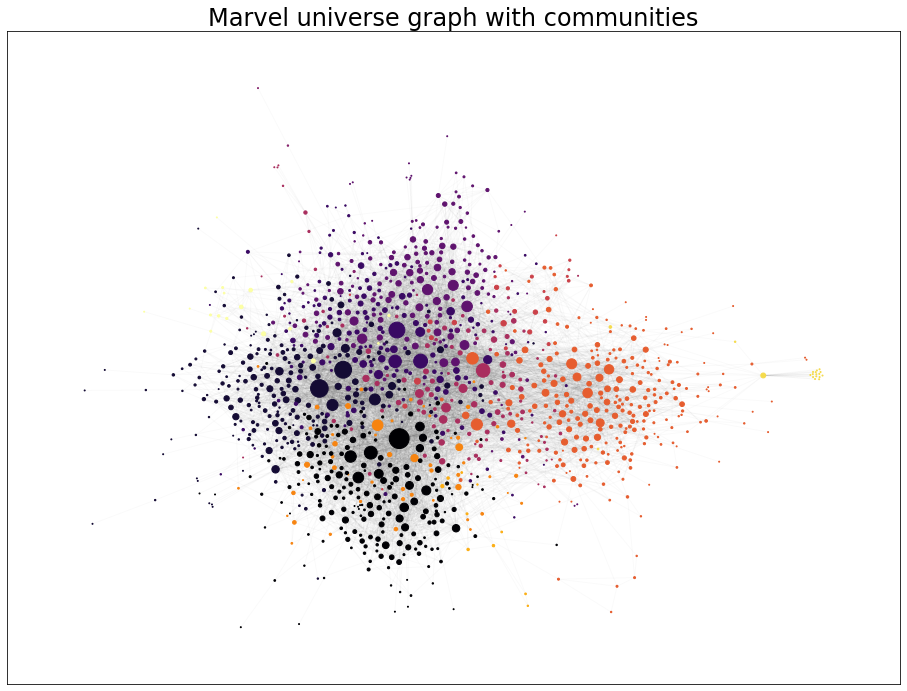

In [68]:
plt.figure(figsize=(16, 12))
cmap = cm.get_cmap("inferno", max(partition.values()) + 1)
nx.draw_networkx_nodes(
    marvel_subgraph, positions, node_size=node_size,
    cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(marvel_subgraph, positions, alpha=0.02)
plt.title("Marvel universe graph with communities", size=24)
plt.show()


# Write a paragraph about your work to identify the communities. 

To find communities we decided to use the Louvain method. We found out that it outperforms other methods in terms of computation time and it is very accurate by focusing on ad-hoc networks with known community structure (https://sites.google.com/site/findcommunities/). 

The algorithm begins with finding small communities by optimizing the modularity of each node. This is done for one node at a time, and for each node, the algorithm checks the change in modularity that would occur if the node were merged with each of its neighbors. On this basis, the node is merged with the neighbor that has the greatest change in modularity. Once a set of small communities  is created and no longer any increase in modularity is obtained by combing smaller communities - the final communities are created. 

Based on wikipedia's definition of modularity, modularity of a network is a measure of the structure of networks which measures the strength of division of a network into modules. The higher the modularity, the better the partition. 
The value of modularity of our network is 0.39 which indicates dense community and the optimal partition. 

When it comes to the size of communities, we obtained 10 different communities with three of them having more than 250 community members. 


### For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.

TF-IDF stands for term frequency–inverse document frequency. It's goal is to show how important a word is to a document in a collection (wikipedia, tf-idf).

The term frequency (tf) of term t in document d is defined as the number of times that t occurs in d. Document frequency (df) is the document frequency of t - the number of documents that contain t. TF-IDF values are generated by the multiplication of Term-Frequency and the Inverse-Document-Frequency. TF-IDF wieight increases with the number of occurences within a document and at the same time it increases with the rarity of the term in the collection. Rare terms are more informative than frequent terms so we want to receive a high weight for rare terms. 



In [35]:
def clean_text(text: t.List[str]) -> t.List[str]:
  """ 
  1) Set everything to lower case
  2) Tokenize the pages into individual strings
  3) Remove all punctuation from your list of tokens 
  4) Lemmatize your words 

  Parameters
  ----------
  text : list of words to process

  Returns
  -------
  cleaned list of words
  """
  text = [word.lower() for word in text if word != '']
  stop_words = stopwords.words('english')
  stop_words.extend(string.punctuation)
  stop_words.extend(["--", "``", "''", "ref", "/ref","'s", "br/", "br", "==", "the", "''"])
  text = [word.replace("|", "") for word in text]
  text = [word for word in text if word not in stop_words]
  lemmatizer = WordNetLemmatizer()
  text = [lemmatizer.lemmatize(word) for word in text]
  return text

In [36]:
def term_freq(text: t.List[str]) -> t.List[str]:
    """ 
    Term frequency for each document in given text 

    Parameters
    ----------
    text: list of strings 

    Returns
    -------
    term frequency
    """
    term_freqs = defaultdict(int)
    for word in text:
        term_freqs[word] += 1/len(text)
    return term_freqs


In [37]:
def inv_doc_freq(corpus):
    """ 
    Calculate inverse document frequency for each word in a corpus 

    Parameters
    ----------
    text: list of strings 

    Returns
    -------
    inverse document term frequency
    """
    words_idf = {}
    words_count = defaultdict(int)
    for text in corpus:
        words_in_text = set()
        for word in text:
            if word not in words_in_text:
                words_in_text.add(word)
                words_count[word] += 1
    
    for word, count in words_count.items():
        words_idf[word] = np.log(len(corpus) / (1 + words_count[word]))
    
    return words_idf


In [38]:
communities = defaultdict(list)
for member, community in partition.items():
    file_ = f"marvel/{member}.txt"
    if not os.path.exists(file_):
        print(f"{file_} does not exist")
        continue
    with open(file_, "r", encoding="utf-8") as ofile:
        content = ofile.read()
        tokens = nltk.tokenize.word_tokenize(content)
        communities[community].extend(clean_text(tokens))

In [39]:
term_freqs = []
for comm, text in communities.items():
    term_freqs.append(term_freq(text))

In [40]:
corpus = [text for text in communities.values()]
idf = inv_doc_freq(corpus)

In [41]:
tfidf_by_comm = []
for comm in term_freqs:
    tfidf = []
    for word, tf in comm.items():
        tfidf.append((word, tf * idf[word]))
    # append sorted tfidf per community in descending order
    tfidf_by_comm.append(sorted(tfidf, key=lambda x: x[1], reverse=True))

In [42]:
# wordclouds
for comm in tfidf_by_comm:
    plt.clf()
    plt.figure(figsize=(20, 10))
    wordcloud_dc = WordCloud(
        collocations=False,
        background_color="white",
        colormap="inferno", 
        width=2048,
        height=1024,
        ).generate_from_frequencies(dict(comm))
    plt.imshow(wordcloud_dc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

The wordclouds seem to be accurate (the characters that we know or we checked, are grouped together in the same word clouds). It helps us to better understand the communities in most of the cases. 

# Sentiment

In [55]:
def preprocess_text(text):
    """
    Preprocess text into list of tokens

    Returns
    -------
    list of tokens
    """
    text = str(text).lower() 
    text = re.sub('[^a-zA-Z]+',' ', text).strip() 
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords.words('english')]    
    return tokens

def calc_sentiment(text, wordlist):
    """
    Calculate sentiment of a text

    Returns
    -------
    Sentiment score
    """
    score = 0
    counter = 0
    for s in text:
        if s in wordlist.word.values:
            counter += 1
            score += wordlist[wordlist.word == s].happiness_average.values[0]
    # if the counter in 0 it mean that in this text we did not find words from wordlist
    if counter == 0:
        return  None
    return score/counter

In [56]:
SENTIMENT = "data/sentiment.pickle"
# load pickle with pre-calculated sentiment if present
if os.path.exists(SENTIMENT):
    with open(SENTIMENT, "rb") as rbfile:
        sentiment = pickle.load(rbfile)
else:
    # load wordlist
    wordlist = pd.read_csv('data/wordlist.txt', sep = '\t')

    sentiment = []
    for character in characters.characters:
        sentiment.append(calc_sentiment(preprocess_text(character.data), wordlist))
    # save to pickle for later use
    with open(SENTIMENT, "wb") as wbfile:
        pickle.dump(sentiment, wbfile)

In [57]:
# store sentiment together with character name
sentiment_data = pd.DataFrame()
sentiment_data['CharacterName'] = [characters.characters[i].name for i in range(len(characters.characters))]
sentiment_data['Sentiment'] = sentiment
sentiment_data = sentiment_data.dropna()
sentiment_data.head(3)

,CharacterName,Sentiment
0,Gregory Herd,5.694319
1,H.E.R.B.I.E.,5.496650
2,Happy Hogan (comics),5.528284


In [58]:
mean_sentiment = sentiment_data.Sentiment.mean()
print(f'Average sentiment of all characters: {mean_sentiment:.2f}')
percentile_10 = sentiment_data.Sentiment.quantile(0.1)
print(f'10th percentile of all characters: {percentile_10:.2f}')
percentile_90 = sentiment_data.Sentiment.quantile(0.9)
print(f'90th percentile of all characters: {percentile_90:.2f}')

Average sentiment of all characters: 5.60
10th percentile of all characters: 5.41
90th percentile of all characters: 5.79


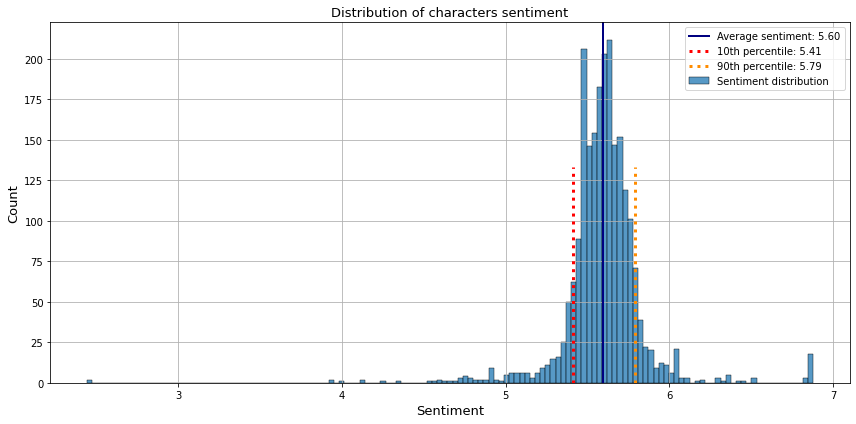

In [59]:
plt.figure(figsize = (12,6))
sns.histplot(sentiment_data.Sentiment);
plt.axvline(mean_sentiment, color = 'navy', linewidth = 2)
plt.xlabel('Sentiment', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.title('Distribution of characters sentiment', fontsize = 13)

plt.axvline(percentile_10, ymax = 0.6, linestyle = ":", linewidth = 3, color = 'red')
plt.axvline(percentile_90, ymax = 0.6, linestyle = ":", linewidth = 3, color = 'darkorange')

plt.legend([f'Average sentiment: {mean_sentiment:.2f}', 
            f'10th percentile: {percentile_10:.2f}', 
            f'90th percentile: {percentile_90:.2f}', 
            'Sentiment distribution'])
plt.grid()
plt.tight_layout()

The distribution of sentiment for all data together is really close to normal distribution. The 10th and 90th percentiles have the same distance to the mean thus the data is not skewed. From this distribution, it can be seen that the average happiness of the characters does not differ a lot and most of the texts are neutral. 

In [60]:
# load data with good/bad characters
good_bad_characters = pd.read_csv('data/good_bad_characters.csv', sep = ',')
good_bad_characters = good_bad_characters.drop('CharacterName', axis = 1)
good_bad_characters.rename(columns={'WikiLink':'CharacterName'}, inplace = True)
good_bad_characters[['good', 'bad']] = good_bad_characters[['good', 'bad']].astype('bool')
good_bad_characters.head(3)

,CharacterName,universe,woman,man,good,bad
0,Abomination (character),Marvel,0,1,False,True
1,Absorbing Man,Marvel,0,1,False,True
2,Achebe (comics),Marvel,0,0,False,False


In [61]:
# leave only characters which are in both data frames
good_bad_characters = good_bad_characters[good_bad_characters.CharacterName.isin(sentiment_data.CharacterName.values)]
sentiment_data = sentiment_data[sentiment_data.CharacterName.isin(good_bad_characters.CharacterName.values)]
# merge data together
sentiment_data = sentiment_data.merge(good_bad_characters, on = 'CharacterName')

In [62]:
mean_sentiment_good = sentiment_data[sentiment_data.good].Sentiment.mean()
mean_sentiment_bad = sentiment_data[sentiment_data.bad].Sentiment.mean()
print(f'Average sentiment of good characters: {mean_sentiment_good:.2f}')
print(f'Average sentiment of bad characters: {mean_sentiment_bad:.2f}')

percentile_10_good = sentiment_data[sentiment_data.good].Sentiment.quantile(0.1)
percentile_10_bad = sentiment_data[sentiment_data.bad].Sentiment.quantile(0.1)
print(f'10th percentile of good characters: {percentile_10_good:.2f}')
print(f'10th percentile of bad characters: {percentile_10_bad:.2f}')

percentile_90_good = sentiment_data[sentiment_data.good].Sentiment.quantile(0.9)
percentile_90_bad = sentiment_data[sentiment_data.bad].Sentiment.quantile(0.9)
print(f'90th percentile of good characters: {percentile_90_good:.2f}')
print(f'90th percentile of bad characters: {percentile_90_bad:.2f}')

Average sentiment of good characters: 5.60
Average sentiment of bad characters: 5.59
10th percentile of good characters: 5.44
10th percentile of bad characters: 5.40
90th percentile of good characters: 5.79
90th percentile of bad characters: 5.78


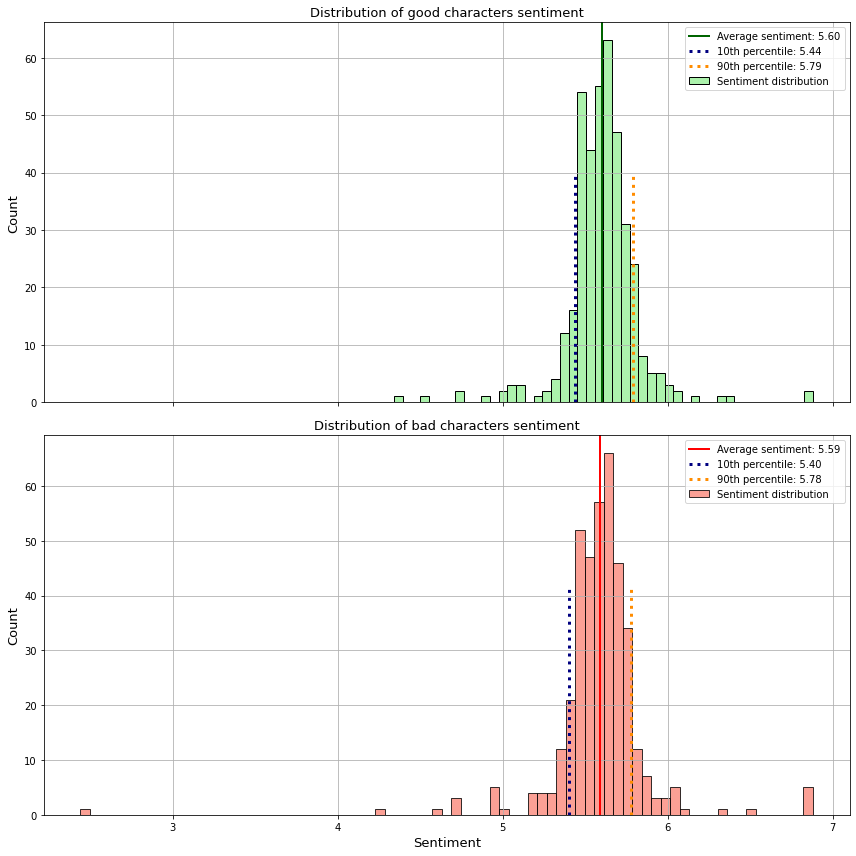

In [63]:
fig, ax = plt.subplots(2,1, figsize = (12,12), sharex = True)

sns.histplot(sentiment_data[sentiment_data.good].Sentiment, ax = ax[0], color = 'lightgreen');
ax[0].axvline(mean_sentiment_good, color = 'darkgreen', linewidth = 2)
ax[0].set_xlabel('Sentiment', fontsize = 13)
ax[0].set_ylabel('Count', fontsize = 13)
ax[0].set_title('Distribution of good characters sentiment', fontsize = 13)

ax[0].axvline(percentile_10_good, ymax = 0.6, linestyle = ":", linewidth = 3, color = 'navy')
ax[0].axvline(percentile_90_good, ymax = 0.6, linestyle = ":", linewidth = 3, color = 'darkorange')

ax[0].legend([f'Average sentiment: {mean_sentiment_good:.2f}', 
              f'10th percentile: {percentile_10_good:.2f}', 
              f'90th percentile: {percentile_90_good:.2f}', 
              'Sentiment distribution'])
ax[0].grid()

sns.histplot(sentiment_data[sentiment_data.bad].Sentiment, ax = ax[1], color = 'salmon');
ax[1].axvline(mean_sentiment_bad, color = 'red', linewidth = 2)
ax[1].set_xlabel('Sentiment', fontsize = 13)
ax[1].set_ylabel('Count', fontsize = 13)
ax[1].set_title('Distribution of bad characters sentiment', fontsize = 13)

ax[1].axvline(percentile_10_bad, ymax = 0.6, linestyle = ":", linewidth = 3, color = 'navy')
ax[1].axvline(percentile_90_bad, ymax = 0.6, linestyle = ":", linewidth = 3, color = 'darkorange')

ax[1].legend([f'Average sentiment: {mean_sentiment_bad:.2f}', 
              f'10th percentile: {percentile_10_bad:.2f}', 
              f'90th percentile: {percentile_90_bad:.2f}', 
              'Sentiment distribution'])
ax[1].grid()
plt.tight_layout()

When comparing good and bad characters sentiment its distribution is still close to the normal distribution. Bad characters have average happiness lower just by 0.1 so there is just a little difference between good and bad characters sentiment and both groups have texts/descriptions written in a neutral way.

## Permutation test

In [64]:
mean_sentiment_good_list = []
mean_sentiment_bad_list = []
for _ in range(1000):
    good_characters = np.random.permutation(sentiment_data.good.values)
    mean_sentiment_good_list.append(sentiment_data[good_characters].Sentiment.mean())

    bad_characters = np.random.permutation(sentiment_data.bad.values)
    mean_sentiment_bad_list.append(sentiment_data[bad_characters].Sentiment.mean())
        

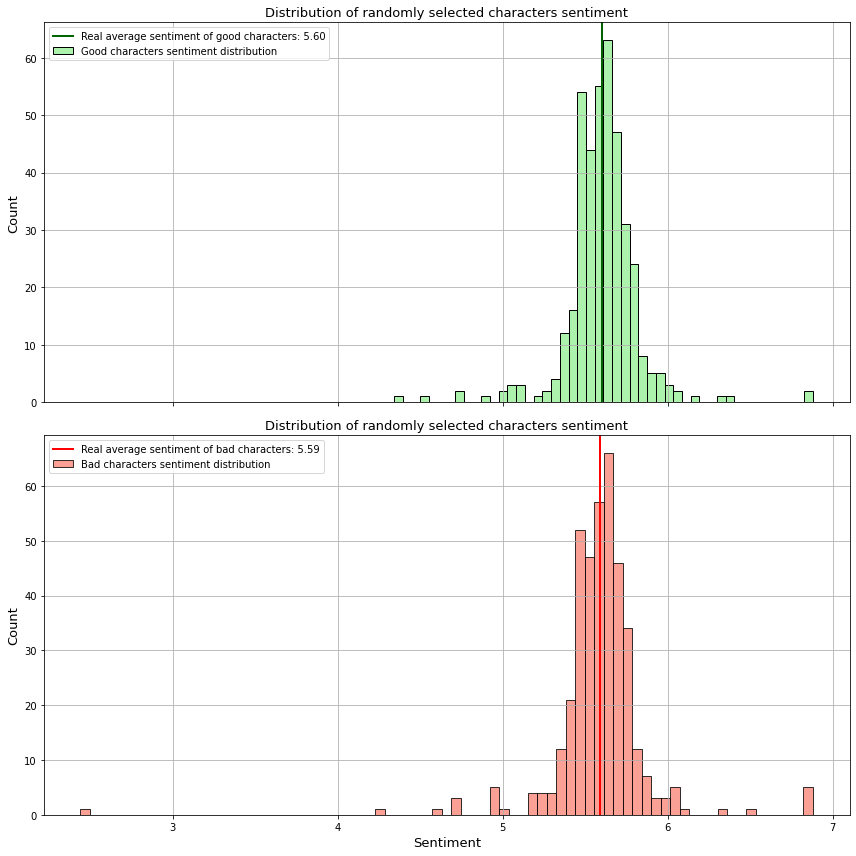

In [65]:
fig, ax = plt.subplots(2,1, figsize = (12,12), sharex = True)

sns.histplot(sentiment_data[sentiment_data.good].Sentiment, ax = ax[0], color = 'lightgreen');
ax[0].axvline(mean_sentiment_good, color = 'darkgreen', linewidth = 2)
ax[0].set_xlabel('Sentiment', fontsize = 13)
ax[0].set_ylabel('Count', fontsize = 13)
ax[0].set_title('Distribution of randomly selected characters sentiment', fontsize = 13)

ax[0].legend([f'Real average sentiment of good characters: {mean_sentiment_good:.2f}', 
              'Good characters sentiment distribution'])
ax[0].grid()


sns.histplot(sentiment_data[sentiment_data.bad].Sentiment, ax = ax[1], color = 'salmon');
ax[1].axvline(mean_sentiment_bad, color = 'red', linewidth = 2)
ax[1].set_xlabel('Sentiment', fontsize = 13)
ax[1].set_ylabel('Count', fontsize = 13)
ax[1].set_title('Distribution of randomly selected characters sentiment', fontsize = 13)

ax[1].legend([f'Real average sentiment of bad characters: {mean_sentiment_bad:.2f}', 
              'Bad characters sentiment distribution'])
ax[1].grid()
plt.tight_layout()

Computing the label permutation test helped to investigate hypotheses about good and bad characters. 

The first hypothesis to check was if the good characters have a higher average value of happiness than randomly selected characters. Based on the upper graph it can be seen that the real average (dark green vertical line) is standing right in the middle of the randomly generated histogram, this means that the average of 5.63 is common for any selected characters and thus we can reject the hypothesis. 
The second hypothesis can be rejected based on the same argument, the real mean of bad characters sentiment is 5.55 which is in the middle of the ensemble of shuffled labels.
 
The reason for having these results is that the data comes from Wikipedia pages, which by default should be written in neutral language.